# Mammalian Enhancer Classification with Genomic Pretraining and Fine Tuning 4-mer stride 2 Model

This notebook uses the enhancer dataset to fine tune the mammalian language model and train a classification model via transfer learning. For more detail about the fine tuning process, see the [Human 4 Short Promoter Classification with Fine Tuning](https://github.com/kheyer/Genomic-ULMFiT/blob/master/Mammals/Human/Promoter%20Classification%20Short%20Sequences/Human%20Promoters%20Short%20Sequences%203%20Classification%20with%20Fine%20Tuning.ipynb) notebook.

To replicate a portion of the paper, the model will be trained on enhancer sequences from Human, Mouse, Dog and Opossum genomes. The multi-species model will then be used to predict on individual species.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
from sklearn.metrics import roc_auc_score

In [3]:
sys.path.append("../../..")
from utils import *

In [4]:
path = Path('F:/genome/mammals/')

# Human

In [5]:
classification_df = pd.read_csv(path/'enhancer_data.csv')

In [6]:
classification_df.head()

,Sequence,Enhancer,Organism,set
0,TGCGGGGTCTTGGCTCTCACGGTCGACTCTGCCTCTCGTGCCCGGG...,positive,Cat,train
1,TCCAGCCACTCCTGAGTCAACATGGCGGGCTTTCTTTGTTGGGCTC...,positive,Cat,train
2,GTGTGCTGGCCACCAGAGGGAGCCAGATCCCCCCTTTTCTCCTCCA...,positive,Cat,train
3,TGGGCGTTTTCACTGCGCGGTCTCTGCTCCTGCCCAACCGCAAGCG...,positive,Cat,train
4,GGCATTGGAGGGACCGAGAATAGGGAGGCCCTGGCCCAAAAAATCA...,positive,Cat,train


In [7]:
classification_df = classification_df[classification_df.Organism == 'Human']

In [8]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [9]:
classification_df.Organism.unique()

array(['Human'], dtype=object)

In [10]:
train_df.shape, valid_df.shape, test_df.shape

((22400, 4), (2800, 4), (2800, 4))

In [11]:
voc = np.load(path/'mammal_vocab_4mer.npy')
model_vocab = GenomicVocab(voc)

In [12]:
len(model_vocab.itos)

257

In [13]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=4, stride=2), n_cpus=4, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [14]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=850, tokenizer=tok, 
                              chunksize=80000, text_cols='Sequence', label_cols='Enhancer', vocab=model_vocab)

In [15]:
len(data.vocab.stoi), len(data.vocab.itos)

(257, 257)

In [18]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.25

In [19]:
learn = get_model_LM(data, drop_mult, config)

In [20]:
learn = learn.to_fp16(dynamic=True);
learn.load('mammal_4mer');

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


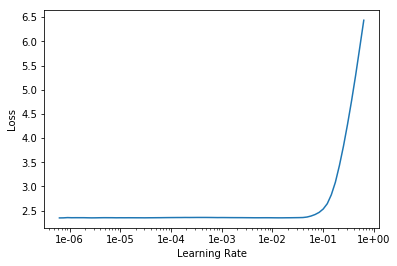

In [23]:
learn.recorder.plot()

# Training


In [24]:
learn.fit_one_cycle(8, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.349788,2.329851,0.255583,01:00
1,2.351739,2.331522,0.254961,01:01
2,2.343735,2.332513,0.255024,01:01
3,2.334220,2.332747,0.254989,01:02
4,2.329257,2.333825,0.254444,01:02
5,2.321462,2.334344,0.254580,01:02
6,2.317093,2.334815,0.254444,01:02
7,2.312235,2.334735,0.254483,01:02


In [25]:
learn.save('enhancer_human_LM_4m2s')
learn.save_encoder('enhancer_human_LM_4m2s_enc')

# Classification

In [14]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab, chunksize=80000,
                                            text_cols='Sequence', label_cols='Enhancer', bs=200)

In [15]:
len(data_clas.vocab.itos), len(data_clas.vocab.stoi)

(257, 257)

In [18]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4,
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.5

In [19]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [20]:
learn = learn.to_fp16(dynamic=True);

In [21]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(257, 400, padding_idx=0)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(257, 400, padding_idx=0)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1,

In [22]:
learn.load_encoder('enhancer_human_LM_4m2s_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


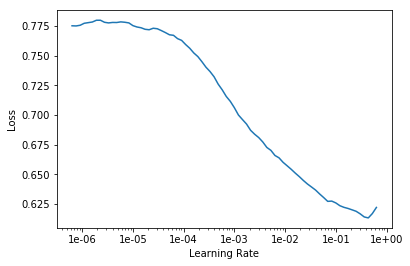

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(3, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.546031,0.530646,0.722500,00:37
1,0.535595,0.514496,0.745000,00:37
2,0.528040,0.514567,0.742500,00:37


In [25]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.530542,0.513937,0.741786,00:45
1,0.520864,0.503942,0.754286,00:45
2,0.494102,0.511250,0.756429,00:45


In [26]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.486362,0.522349,0.745714,01:06
1,0.471780,0.522892,0.738929,01:06
2,0.446599,0.536168,0.748214,01:06


In [27]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.437675,0.537540,0.743571,01:23
1,0.428340,0.548236,0.745000,01:23
2,0.420516,0.549075,0.745357,01:23


In [28]:
learn.save('enhancer_human_clas_finetune_4m2s')

In [21]:
learn.load('enhancer_human_clas_finetune_4m2s');

In [29]:
data_test = GenomicTextClasDataBunch.from_df(path, train_df, test_df, 
                                                 tokenizer=tok, vocab=model_vocab, text_cols='Sequence', 
                                                 label_cols='Enhancer', bs=200)

In [30]:
learn.data = data_test
preds = learn.get_preds(ordered=True)
p = torch.argmax(preds[0], dim=1)
y = preds[1]

In [31]:
roc_auc_score(y, preds[0][:,1])

0.8043630102040816

In [32]:
get_scores(learn)

Accuracy: 0.7332142857142857
False Positives: 0.1525
False Negatives: 0.11428571428571428
Recall: 0.7714285714285715
Precision: 0.7166556071665561
Specificity: 0.695
MCC: 0.46779684956908507


# Mouse

In [5]:
classification_df = pd.read_csv(path/'enhancer_data.csv')

In [6]:
classification_df = classification_df[classification_df.Organism == 'Mouse']

In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
classification_df.Organism.unique()

array(['Mouse'], dtype=object)

In [9]:
train_df.shape, valid_df.shape, test_df.shape

((22399, 4), (2800, 4), (2800, 4))

In [10]:
voc = np.load(path/'mammal_vocab_4mer.npy')
model_vocab = GenomicVocab(voc)

In [11]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=4, stride=2), n_cpus=4, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [12]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=850, tokenizer=tok, 
                              chunksize=80000, text_cols='Sequence', label_cols='Enhancer', vocab=model_vocab)

In [13]:
len(data.vocab.stoi), len(data.vocab.itos)

(257, 257)

In [16]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.25

In [17]:
learn = get_model_LM(data, drop_mult, config)

In [18]:
learn = learn.to_fp16(dynamic=True);
learn.load('mammal_4mer');

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


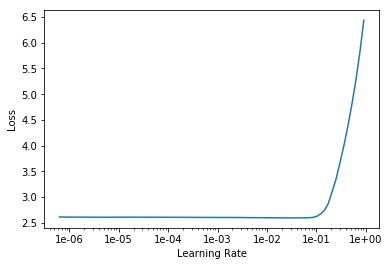

In [21]:
learn.recorder.plot()

# Training


In [22]:
learn.fit_one_cycle(8, 3e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.583162,2.546462,0.172328,01:01
1,2.527814,2.479430,0.197534,01:01
2,2.473003,2.449397,0.208479,01:01
3,2.440165,2.437721,0.212915,01:02
4,2.414741,2.431766,0.215144,01:02
5,2.395850,2.429384,0.216485,01:02
6,2.379077,2.428881,0.216758,01:02
7,2.371653,2.429132,0.216952,01:02


In [23]:
learn.save('enhancer_mouse_LM_4m2s')
learn.save_encoder('enhancer_mouse_LM_4m2s_enc')

# Classification

In [12]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab, chunksize=80000,
                                            text_cols='Sequence', label_cols='Enhancer', bs=200)

In [13]:
len(data_clas.vocab.itos), len(data_clas.vocab.stoi)

(257, 257)

In [16]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4,
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.55

In [17]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [18]:
learn = learn.to_fp16(dynamic=True);

In [19]:
learn.load_encoder('enhancer_mouse_LM_4m2s_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


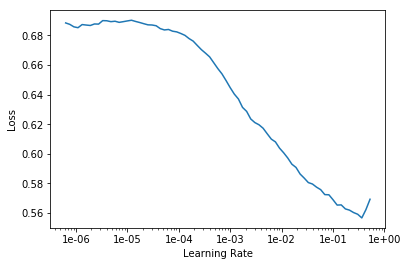

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(3, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.488228,0.500678,0.785000,00:36
1,0.478540,0.469524,0.784643,00:37
2,0.465301,0.459623,0.784286,00:37


In [22]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.464876,0.468854,0.774286,00:45
1,0.454035,0.452260,0.786071,00:45
2,0.437280,0.457996,0.784286,00:45


In [23]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.431495,0.449123,0.785714,01:06
1,0.423086,0.452725,0.786071,01:05
2,0.403260,0.452432,0.786429,01:05


In [24]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.402321,0.452951,0.788571,01:22
1,0.397491,0.456321,0.786071,01:23
2,0.386197,0.456536,0.786071,01:23


In [25]:
learn.save('enhancer_mouse_clas_finetune_4m2s')

In [19]:
learn.load('enhancer_mouse_clas_finetune_4m2s');

In [26]:
data_test = GenomicTextClasDataBunch.from_df(path, train_df, test_df, 
                                                 tokenizer=tok, vocab=model_vocab, text_cols='Sequence', 
                                                 label_cols='Enhancer', bs=200)

In [27]:
learn.data = data_test
preds = learn.get_preds(ordered=True)
p = torch.argmax(preds[0], dim=1)
y = preds[1]

In [28]:
roc_auc_score(y, preds[0][:,1])

0.8765364795918367

In [29]:
get_scores(learn)

Accuracy: 0.7953571428571429
False Positives: 0.10964285714285714
False Negatives: 0.095
Recall: 0.81
Precision: 0.7869535045107564
Specificity: 0.7807142857142857
MCC: 0.5909677627301737


# Dog

In [6]:
classification_df = pd.read_csv(path/'enhancer_data.csv')

In [7]:
classification_df = classification_df[classification_df.Organism == 'Dog']

In [8]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [9]:
classification_df.Organism.unique()

array(['Dog'], dtype=object)

In [10]:
train_df.shape, valid_df.shape, test_df.shape

((22400, 4), (2800, 4), (2800, 4))

In [11]:
voc = np.load(path/'mammal_vocab_4mer.npy')
model_vocab = GenomicVocab(voc)

In [12]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=4, stride=2), n_cpus=4, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [12]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=850, tokenizer=tok, 
                              chunksize=80000, text_cols='Sequence', label_cols='Enhancer', vocab=model_vocab)

In [13]:
len(data.vocab.stoi), len(data.vocab.itos)

(257, 257)

In [16]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.25

In [17]:
learn = get_model_LM(data, drop_mult, config)

In [18]:
learn = learn.to_fp16(dynamic=True);
learn.load('mammal_4mer');

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


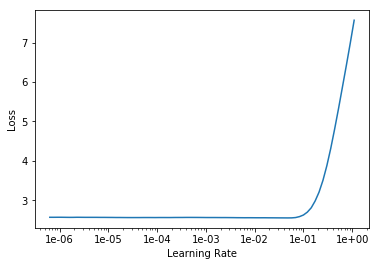

In [21]:
learn.recorder.plot()

# Training


In [22]:
learn.fit_one_cycle(8, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.554703,2.521046,0.189245,01:01
1,2.506541,2.472209,0.206064,01:01
2,2.475771,2.460922,0.209706,01:01
3,2.459997,2.455425,0.211539,01:02
4,2.445399,2.453268,0.212150,01:01
5,2.435509,2.452147,0.212438,01:01
6,2.433070,2.451989,0.212665,01:02
7,2.428391,2.451621,0.212814,01:02


In [23]:
learn.save('enhancer_dog_LM_4m2s')
learn.save_encoder('enhancer_dog_LM_4m2s_enc')

# Classification

In [13]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab, chunksize=80000,
                                            text_cols='Sequence', label_cols='Enhancer', bs=200)

In [14]:
len(data_clas.vocab.itos), len(data_clas.vocab.stoi)

(257, 257)

In [17]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4,
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.45

In [18]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [19]:
learn = learn.to_fp16(dynamic=True);

In [20]:
learn.load_encoder('enhancer_dog_LM_4m2s_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


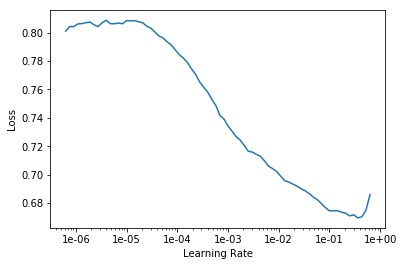

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(3, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.594144,0.581402,0.690714,00:37
1,0.581337,0.564510,0.710357,00:37
2,0.573584,0.563035,0.713214,00:37


In [23]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.577111,0.567675,0.706429,00:45
1,0.562858,0.553712,0.723571,00:45
2,0.536109,0.544555,0.733571,00:45


In [24]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.532399,0.555848,0.727500,01:06
1,0.518021,0.555948,0.715714,01:06
2,0.480635,0.571230,0.717500,01:06


In [25]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.461075,0.579945,0.719286,01:23
1,0.453606,0.588734,0.714286,01:23
2,0.449003,0.585047,0.713929,01:23


In [26]:
learn.save('enhancer_dog_clas_finetune_4m2s')

In [19]:
learn.load('enhancer_dog_clas_finetune_4m2s');

In [27]:
data_test = GenomicTextClasDataBunch.from_df(path, train_df, test_df, 
                                                 tokenizer=tok, vocab=model_vocab, text_cols='Sequence', 
                                                 label_cols='Enhancer', bs=200)

In [28]:
learn.data = data_test
preds = learn.get_preds(ordered=True)
p = torch.argmax(preds[0], dim=1)
y = preds[1]

In [29]:
roc_auc_score(y, preds[0][:,1])

0.7718257653061225

In [30]:
get_scores(learn)

Accuracy: 0.7064285714285714
False Positives: 0.17
False Negatives: 0.12357142857142857
Recall: 0.7528571428571429
Precision: 0.6888888888888889
Specificity: 0.66
MCC: 0.41464865646889665


# Opossum

In [5]:
classification_df = pd.read_csv(path/'enhancer_data.csv')

In [6]:
classification_df = classification_df[classification_df.Organism == 'Opossum']

In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
classification_df.Organism.unique()

array(['Opossum'], dtype=object)

In [9]:
train_df.shape, valid_df.shape, test_df.shape

((22399, 4), (2800, 4), (2800, 4))

In [10]:
voc = np.load(path/'mammal_vocab_4mer.npy')
model_vocab = GenomicVocab(voc)

In [11]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=4, stride=2), n_cpus=4, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [12]:
data = GenomicTextLMDataBunch.from_df(path, train_df, valid_df, bs=850, tokenizer=tok, 
                              chunksize=80000, text_cols='Sequence', label_cols='Enhancer', vocab=model_vocab)

In [13]:
len(data.vocab.stoi), len(data.vocab.itos)

(257, 257)

In [16]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.25

In [17]:
learn = get_model_LM(data, drop_mult, config)

In [18]:
learn = learn.to_fp16(dynamic=True);
learn.load('mammal_4mer');

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


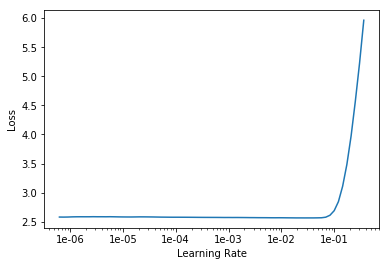

In [21]:
learn.recorder.plot()

# Training


In [22]:
learn.fit_one_cycle(8, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.562935,2.551314,0.172515,01:01
1,2.529602,2.506126,0.188557,01:01
2,2.487861,2.480377,0.198378,01:01
3,2.461987,2.467022,0.203545,01:02
4,2.444312,2.457749,0.207123,01:02
5,2.427987,2.452974,0.209021,01:02
6,2.419663,2.451003,0.209611,01:02
7,2.416976,2.450779,0.209733,01:02


In [23]:
learn.save('enhancer_opossum_LM_4m2s')
learn.save_encoder('enhancer_opossum_LM_4m2s_enc')

# Classification

In [12]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab, chunksize=80000,
                                            text_cols='Sequence', label_cols='Enhancer', bs=200)

In [13]:
len(data_clas.vocab.itos), len(data_clas.vocab.stoi)

(257, 257)

In [16]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4,
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.5

In [17]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [18]:
learn = learn.to_fp16(dynamic=True);

In [19]:
learn.load_encoder('enhancer_opossum_LM_4m2s_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


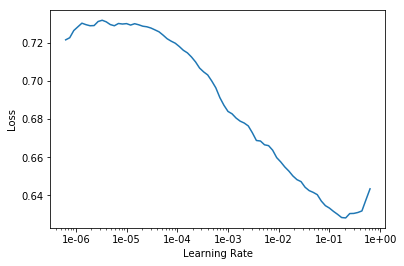

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(3, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.583501,0.584110,0.687143,00:37
1,0.570288,0.571885,0.693929,00:37
2,0.561860,0.559621,0.699286,00:37


In [22]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.560861,0.575103,0.702143,00:45
1,0.551785,0.546237,0.714286,00:45
2,0.525330,0.540874,0.718929,00:45


In [23]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.522607,0.537892,0.721786,01:06
1,0.508544,0.558525,0.705357,01:05
2,0.473870,0.562403,0.720000,01:06


In [24]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.466932,0.563035,0.717857,01:22
1,0.457603,0.563079,0.717143,01:23
2,0.452218,0.567429,0.716429,01:23


In [25]:
learn.save('enhancer_opossum_clas_finetune_4m2s')

In [27]:
learn.load('enhancer_opossum_clas_finetune_4m2s');

In [26]:
data_test = GenomicTextClasDataBunch.from_df(path, train_df, test_df, 
                                                 tokenizer=tok, vocab=model_vocab, text_cols='Sequence', 
                                                 label_cols='Enhancer', bs=200)

In [27]:
learn.data = data_test
preds = learn.get_preds(ordered=True)
p = torch.argmax(preds[0], dim=1)
y = preds[1]

In [28]:
roc_auc_score(y, preds[0][:,1])

0.7868436224489797

In [29]:
get_scores(learn)

Accuracy: 0.7110714285714286
False Positives: 0.14285714285714285
False Negatives: 0.14607142857142857
Recall: 0.7078571428571429
Precision: 0.7124370956146657
Specificity: 0.7142857142857143
MCC: 0.4221515802630845
